In [31]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

from torchvision.models import VGG16_Weights, MobileNet_V2_Weights, ResNet18_Weights, resnet18
from PIL import Image
import requests

In [32]:
# Sprawdzenie dostępności GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Używane urządzenie: {device}")

Używane urządzenie: cuda


In [33]:
# Definiowanie ścieżek do datasetu - lokalnie, potem plan jest taki, żeby pobierało z kaggle
# https://www.kaggle.com/datasets/jarocichociemny420/msc-testdataset
data_dir = '/media/bartek/889CBCD79CBCC14C/msc-testdataset'
train_dir = f'{data_dir}/train'
val_dir = f'{data_dir}/val'

In [34]:
classes = ('mug', 'parfum')

In [35]:
# Definicja transformacji dla treningu i walidacji
transform_train = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),      # 3 kanały - RGB
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # różne
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Ładowanie datasetu
training_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
validation_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=20, shuffle=False)

In [36]:
# konwersja tensora na obraz
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5)) + np.array((0.5))
    image = image.clip(0, 1)
    return image

In [37]:
# Wczytanie modelu
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model = model.to(device)

# Zamrożenie wcześniejszych warstw ResNet
for param in model.parameters():
    param.requires_grad = False

# Zmiana ostatniej warstwy na klasyfikację 2 klas
n_inputs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),  # Dropout dla lepszej generalizacji
    nn.Linear(n_inputs, len(classes))
)
model = model.to(device)  # Przeniesienie na GPU

# Funkcja kosztu i optymalizator
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0005)

# Trenowanie modelu
epochs = 5
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
    running_loss = 0.0
    running_corrects = 0
    val_running_loss = 0.0
    val_running_corrects = 0

    model.train()
    for inputs, labels in training_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data).item()
        running_loss += loss.item() * inputs.size(0)

    model.eval()
    with torch.no_grad():
        for val_inputs, val_labels in validation_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)

            _, val_preds = torch.max(val_outputs, 1)
            val_running_corrects += torch.sum(val_preds == val_labels.data).item()
            val_running_loss += val_loss.item() * val_inputs.size(0)

    epoch_loss = running_loss / len(training_dataset)
    epoch_acc = running_corrects / len(training_dataset)

    val_epoch_loss = val_running_loss / len(validation_dataset)
    val_epoch_acc = val_running_corrects / len(validation_dataset)

    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)

    print(f'Epoch {e+1}: Training loss: {epoch_loss:.4f}, Training accuracy: {epoch_acc:.4f}')
    print(f'Validation loss: {val_epoch_loss:.4f}, Validation accuracy: {val_epoch_acc:.4f}')

Epoch 1: Training loss: 0.8087, Training accuracy: 0.5159
Validation loss: 0.6423, Validation accuracy: 0.6047
Epoch 2: Training loss: 0.7484, Training accuracy: 0.5536
Validation loss: 0.6266, Validation accuracy: 0.6512
Epoch 3: Training loss: 0.7254, Training accuracy: 0.5797
Validation loss: 0.6000, Validation accuracy: 0.6744
Epoch 4: Training loss: 0.6697, Training accuracy: 0.5768
Validation loss: 0.5788, Validation accuracy: 0.7093
Epoch 5: Training loss: 0.6732, Training accuracy: 0.6203
Validation loss: 0.5626, Validation accuracy: 0.7209


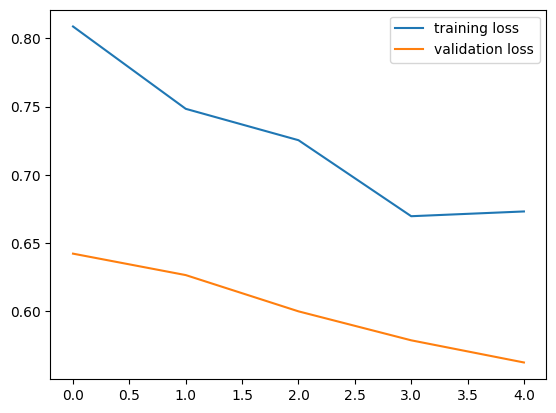

In [38]:
# Wizualizacja wyników treningu
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()
plt.show()

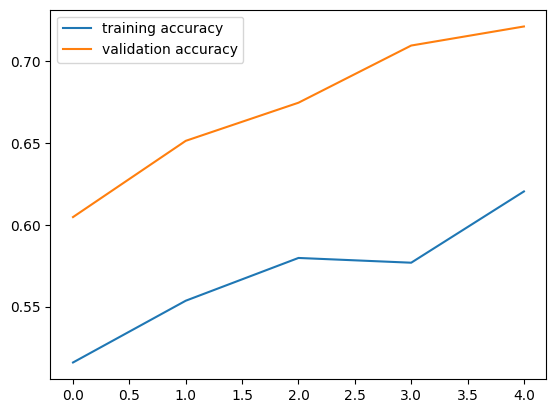

In [39]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()
plt.show()

In [40]:
print(f'Training accuracy: {epoch_acc:.4f}')
print(f'Validation accuracy: {val_epoch_acc:.4f}')

Training accuracy: 0.6203
Validation accuracy: 0.7209


In [41]:
iterations = 100
obj = 'mug'

# mógłbym w sumie testować to na swoich zdjęciach, ale z ciekawości testowałem model na obrazach z internetu
url = 'https://porcelanabydgoszcz.pl/wp-content/uploads/2022/05/Plus-Gold-Kubek-3.jpg'
sum = 0.0

'''
response = requests.get(url, stream=True)
img = Image.open(response.raw)
img = transform(img).unsqueeze(0)
output = model(img)
_, pred = torch.max(output, 1)
print(f'Przewidziany obiekt: {classes[pred.item()]}')
'''

correct_predictions = 0  # Licznik poprawnych predykcji

for i in range(iterations):
    response = requests.get(url, stream=True)
    img = Image.open(response.raw)
    img = transform(img).unsqueeze(0)
    output = model(img)
    _, pred = torch.max(output, 1)
    # Sprawdzamy czy model poprawnie przewidział obiekt porównując wynik z zadanym obrazem
    if classes[pred.item()] == obj:
        correct_predictions += 1

accuracy = correct_predictions / iterations
print(f'Accuracy: {accuracy:.2f}')

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor